In [68]:
import importlib
import data_preprocessor
import re
import pandas as pd

from helper_functions import load_dataset, save_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from data_preprocessor import DataPreprocessor
importlib.reload(data_preprocessor)

<module 'data_preprocessor' from 'F:\\PyCharmProjects\\DataMining\\Assignment3\\src\\data_preprocessor.py'>

### Loading the dataset

In [69]:
data = load_dataset("../data/assignment3_articles.xlsx")

## 1) Data Inspection and Preparation

First, we do some basic inspection of the dataset, such as checking the first few rows, the data types, the amount of missing values, and the value counts of certain columns.

In [70]:
data

,index,headlines,description,content
0,0,Rupee ends 1 paisa lower at 83.38 against US d...,"Besides, selling pressure in the domestic equi...",The rupee consolidated in a narrow range and s...
1,1,"India vs Syria Live Streaming, AFC Asian Cup 2...","AFC Asian Cup Live Streaming, India vs Syria F...",India vs Syria AFC Asia Cup Live Streaming Det...
2,2,"PM Modi to interact with VCs, teachers, studen...",G20 University Connect: The commission has ask...,The University Grants Commission (UGC) is orga...
3,3,"How to remove bloatware apps from Samsung, Rea...",Smartphone companies often ship Android phones...,Smartphone manufacturers often pack new Androi...
4,4,NEET SS 2023 result declared; counselling sche...,NEET SS 2023 Result: Candidates who appeared f...,The National Board of Examinations Medical Sci...
...,...,...,...,...
2495,2495,Google Search and Lens can now visualise STEM ...,Google Search and Lens can now help students w...,Google has been consistently improving its Sea...
2496,2496,Arsenal’s Partey an injury doubt as Arteta rel...,Partey came off at halftime during Arsenal's F...,Arsenal midfielder Thomas Partey is still an i...
2497,2497,"iQOO 12 will get 3 Android updates, will not h...","iQOO says its upcoming flagship phone, running...",iQOO is all set to launch its upcoming flagshi...
2498,2498,Lava Blaze Pro 5G review: Is this the best 5G ...,Lava Blaze Pro 5G is an excellent 5G smartphon...,"In less than a year, India has accounted for o..."


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        2500 non-null   int64 
 1   headlines    2500 non-null   object
 2   description  2500 non-null   object
 3   content      2500 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.3+ KB


### Preprocessing the text data

In [72]:
preprocessor = DataPreprocessor()

In [73]:
# get first row and last column
data.iloc[0, -1]

'The rupee consolidated in a narrow range and settled 1 paisa lower at 83.38 (provisional) against the US dollar on Tuesday, as investors preferred to remain cautious ahead of the domestic inflation data release and upcoming US Fed meeting.\nBesides, selling pressure in the domestic equity markets dented market sentiments, forex traders said.\nHowever, a weaker American currency against major currencies overseas restricted the loss in the local currency, they added.\nADVERTISEMENT\nAt the interbank foreign exchange market, the local unit opened at 83.36 and settled at 83.38 (provisional) against the greenback, registering a loss of 1 paisa from its previous close.\nDuring intra-day, the rupee touched a high of 83.35 and hit the lowest level of 83.39.\nOn Monday, the domestic currency settled at 83.37 against the US dollar.\nInvestors largely remained concerned over the domestic inflation data as well as industrial production numbers to be announced later in the day.\nADVERTISEMENT\nCur

In [74]:
preprocessor.preprocess_text(data.iloc[0, -1])

'rupe consolid narrow rang settl paisa lower provision us dollar tuesday investor prefer remain cautiou ahead domest inflat data releas upcom us fed meet besid sell pressur domest equiti market dent market sentiment forex trader said howev weaker american currenc major currenc oversea restrict loss local currenc ad interbank foreign exchang market local unit open settl provision greenback regist loss paisa previou close intraday rupe touch high hit lowest level monday domest currenc settl us dollar investor larg remain concern domest inflat data well industri product number announc later day currenc trader also await us feder reserv monetari polici decis like announc later week upcom focu us cpi data even expect per cent monthonmonth basi lower yearonyear figur per cent anticip mix reaction rupe seem unaffect persist within broad rang jateen trivedi vp research analyst lkp secur said meanwhil dollar index gaug greenback strength basket six currenc trade per cent lower tuesday brent cru

### a

In [75]:
def count_numbers(text):
    """
    Count the occurrences of numbers in the text.
    """
    # Define a regular expression pattern to match numbers
    pattern = r'\b\d+[,.]\d+\b|\b\d+[,.]?\b|\b[,.]\d+\b'
    return len(re.findall(pattern, text))

def preprocess_col(preprocessor: DataPreprocessor, col: pd.Series, h_pct: float = 0, l_pct: float = 0):
    """ 
    Preprocesses a column of text data using the preprocessor (cfr. data_preprocessor.py), 
    and by removing the top $h_pct of the most frequent words and the top $l_pct of the least frequent words.
    
    Inspired partly by: https://medium.com/analytics-vidhya/introduction-to-text-classification-in-python-659eccf6b2e
    
    :param preprocessor: preprocessor object
    :param col: column of text data
    :param h_pct: "the percentage of high frequency words to remove from the corpus"
    :param l_pct: "the percentage of low frequency words to remove from the corpus"
    :return: 
    """

    col = col.apply(preprocessor.preprocess_text)
    
    if h_pct != 0:
        #removing the top $h_pct of the most frequent words 
        high_freq = pd.Series(' '.join(col).split()).value_counts()[:int(pd.Series(' '.join(col).split()).count()*h_pct/100)]
        rem_high = col.apply(lambda x: " ".join(x for x in x.split() if x not in high_freq))
    else:
        rem_high = col
    
    if l_pct != 0:
        #removing the top $l_pct of the least frequent words
        low_freq = pd.Series(' '.join(rem_high).split()).value_counts()[:-int(pd.Series(' '.join(rem_high).split()).count()*l_pct/100):-1]
        rem_low = rem_high.apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
    else:
        rem_low = rem_high
    
    return rem_low

In [76]:
# count amount of numbers in content column
data['amount_of_numbers'] = data['content'].apply(count_numbers)

data['preprocessed_content'] = preprocess_col(preprocessor, data['content'], h_pct=1, l_pct=1)
data['concatenated'] = data['headlines'] + ' ' + data['description'] + ' ' + data['preprocessed_content']
data['preprocessed_concat'] = preprocess_col(preprocessor, data['concatenated'], h_pct=0, l_pct=0)

data_preprocessed = data.drop(columns=['headlines', 'description', 'content', 'preprocessed_content', 'concatenated'])

In [77]:
data_preprocessed

,index,amount_of_numbers,preprocessed_concat
0,0,27,rupe end paisa lower us dollar besid sell pres...
1,1,5,india vs syria live stream afc asian cup watch...
2,2,4,pm modi interact vc teacher student ugc g20 un...
3,3,0,remov bloatwar app samsung realm xiaomi vivo r...
4,4,2,neet ss result declar counsel schedul soon nat...
...,...,...,...
2495,2495,0,googl search len visualis stem model help calc...
2496,2496,1,arsen partey injuri doubt arteta reli jorginho...
2497,2497,10,iqoo get android updat hot app hot game iqoo s...
2498,2498,1,lava blaze pro 5g review best 5g phone rs 15k ...


In [78]:
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(data_preprocessed['preprocessed_concat']) # Vectorize preprocessed text data

vectorized_data_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())

# # Concatenate vectorized DataFrame with original DataFrame
# final_df = pd.concat([data, vectorized_data_df], axis=1)

# Save DataFrame with vectorized data
# final_df.to_csv('vectorized_articles.csv', index=False)  # Save to CSV file

In [79]:
vectorized_data_df

,03httpstco8pkjgg8udm,03mm,0f,1000plu,1000th,10011200th,100inch,100million,100th,103inch,...,zonewhuev,zoolog,zoom,zorzi,zouma,zoya,zozo,zuckerberg,zulfon,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clustering

In [80]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


tfidf_features = vectorized_data_df
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_features)
cluster_labels = kmeans.labels_

# Evaluate clustering using silhouette score (optional)
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: 0.005160944396573139


In [81]:
tfidf_features['cluster'].value_counts()

cluster
5    1232
4     268
2     210
6     186
3     179
0     172
7      78
1      66
9      58
8      51
Name: count, dtype: int64

In [82]:
centroids = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()

# Print top words for each cluster
for i in range(num_clusters):
    cluster_center = centroids[i]
    top_indices = cluster_center.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names[idx] for idx in top_indices]  # Map indices to words
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: iit, student, jee, univers, main, programm, rank, cours, year, institut
Cluster 2: collect, kapoor, box, offic, ranbir, anim, day, film, rs, crore
Cluster 3: per, cent, rs, crore, price, bank, sensex, inflat, rbi, market
Cluster 4: ai, galaxi, samsung, gener, chatgpt, new, openai, power, s24, user
Cluster 5: khan, vs, test, australia, india, shah, rukh, kohli, ind, cup
Cluster 6: india, said, say, film, year, game, first, indian, world, time
Cluster 7: appl, googl, featur, new, app, tech, news, pro, iphon, today
Cluster 8: ug, neet, cuet, counsel, pg, topper, tip, admiss, exam, registr
Cluster 9: exam, class, board, cbse, datesheet, student, compart, school, schedul, date
Cluster 10: result, check, websit, offici, declar, exam, student, orissaresultsnicin, appear, score


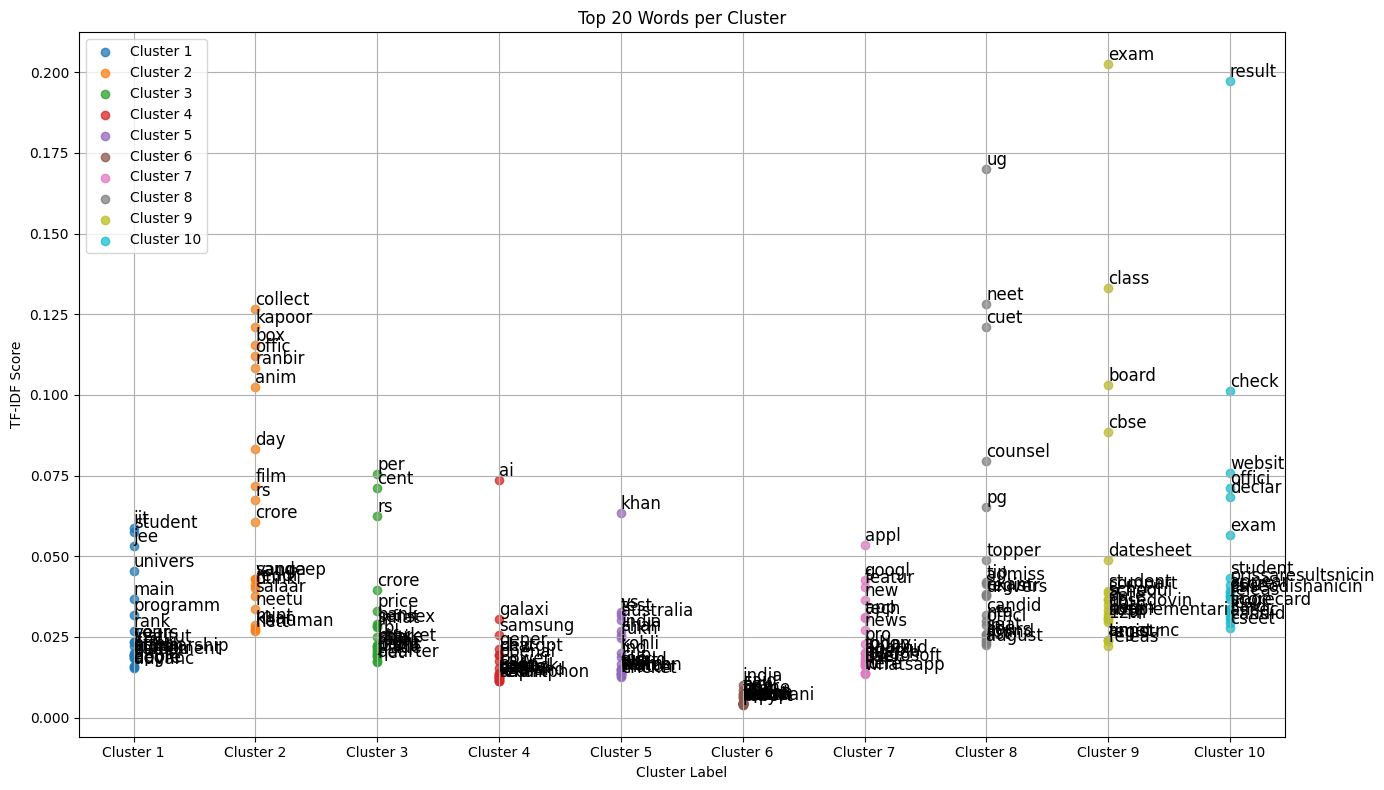

In [83]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 8))

for i in range(num_clusters):
    cluster_center = centroids[i]
    top_indices = cluster_center.argsort()[::-1][:20]  # Get indices of top 20 words
    top_words = [feature_names[idx] for idx in top_indices]  # Map indices to words
    tfidf_scores = cluster_center[top_indices]  # Get TF-IDF scores for top words
    
    # Plot points
    plt.scatter([i] * 20, tfidf_scores, label=f'Cluster {i+1}', alpha=0.75)
    
    # Annotate points with words
    for j, (word, score) in enumerate(zip(top_words, tfidf_scores)):
        plt.text(i, score, word, fontsize=12, ha='left', va='bottom')

# Customize plot
plt.xlabel('Cluster Label')
plt.ylabel('TF-IDF Score')
plt.title('Top 20 Words per Cluster')
plt.xticks(range(num_clusters), [f'Cluster {i+1}' for i in range(num_clusters)])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [84]:
from sklearn_extra.cluster import KMedoids

# Assuming 'tfidf_features' contains TF-IDF scores as features for each document
tfidf_features = vectorized_data_df

# Choose the number of clusters
num_clusters = 5

# Initialize K-Medoids clustering algorithm
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42)

# Fit K-Medoids to the TF-IDF features
kmedoids.fit(tfidf_features)

# Get cluster labels for each document
cluster_labels = kmedoids.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: 0.0009887625901043424
